In [2]:
import xarray as xr
import datetime as dt
import pandas as pd
from datetime import timedelta
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.readers import reader_global_landmask
from opendrift.models.oceandrift import OceanDrift
import os, requests
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, LinearSegmentedColormap
import matplotlib
import cartopy.crs as ccrs
import numpy as np
import scipy.ndimage as ndimage
%matplotlib inline
import warnings
import glob
from PIL import Image
warnings.filterwarnings('ignore')


In [3]:
def make_map():
    fig = plt.figure(figsize=(12,9))
    cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)
    ax.coastlines('10m', linewidth=0.8,zorder=200)
    ax.set_xlim(-123.,-122.3)
    ax.set_ylim(37.5,38.05)
    return(fig, ax)

## Model Setup ##

__1. Create the Model Object__

We will be using the OceanDrift model, which simulates ocean surface drifting, forced by surface currents, wind, and/or stokes drift.

In [4]:

o = OceanDrift(loglevel=40) # Setting the log level will give the user different amounts of info (0=Debug (all), 20=Minimum, 50=None)


__Create readers for forcing the model__

There are a couple of different types of readers. Here we will be using the `reader_netCDF_CF_generic` class and the `reader_global_landmask`.

__`reader_netCDF_CF_generic`__: Takes any CF-compliant netCDF file (including a thredds endpoint). Because the CF name for surface current velocities are: 'x_sea_water_velocity' and 'y_sea_water_velocity', the reader is able to identify the data.

__`reader_global_landmask`__ will create a landmask from the __Global Self-consistent, Hierarchical, High-resolution Geography Database (GSHHG)__ dataset.

In [5]:
reader_1km = reader_netCDF_CF_generic.Reader("http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/1km/hourly/RTV/HFRADAR_US_West_Coast_1km_Resolution_Hourly_RTV_best.ncd")
reader_500m = reader_netCDF_CF_generic.Reader("http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/500m/hourly/RTV/HFRADAR_US_West_Coast_500m_Resolution_Hourly_RTV_best.ncd")
reader_2km = reader_netCDF_CF_generic.Reader("http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd")
reader_6km = reader_netCDF_CF_generic.Reader("http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd")

In [5]:
print(reader_6km)
print(OceanDrift.required_variables)

Reader: http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd
Projection: 
  +proj=latlong
Coverage: [degrees]
  xmin: -130.360001   xmax: -115.805565   step: 0.0624695   numx: 233
  ymin: 30.250000   ymax: 49.992039   step: 0.0539398   numy: 367
  Corners (lon, lat):
    (-130.36,  49.99)  (-115.81,  49.99)
    (-130.36,  30.25)  (-115.81,  30.25)
Vertical levels [m]: 
  Not specified
Available time range:
  start: 2012-01-01 00:00:00   end: 2020-10-21 17:00:00   step: 1:00:00
    77202 times (1096 missing)
Variables:
  time
  forecast_reference_time
  forecast_period
  surface_eastward_sea_water_velocity
  surface_northward_sea_water_velocity
  x_sea_water_velocity
  y_sea_water_velocity

['x_sea_water_velocity', 'y_sea_water_velocity', 'x_wind', 'y_wind', 'upward_sea_water_velocity', 'ocean_vertical_diffusivity', 'sea_surface_wave_significant_height', 'sea_surface_wave_stokes_drift_x_velocity', 'sea_surface_wave_sto

In [6]:
reader_landmask = reader_global_landmask.Reader(
                       extent=[-123.99,  -122.177032, 37.244221, 38.233120])  # lonmin, lonmax, latmin, latmax

ERROR:root:could not verify read permissions for group and others on landmask.
Traceback (most recent call last):
  File "/home/pdaniel/anaconda3/lib/python3.8/site-packages/opendrift_landmask_data-0.6-py3.8.egg/opendrift_landmask_data/mask.py", line 77, in __check_permissions__
    if not os.stat(self.lockf).st_mode & 0o777 == 0o777:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/landmask/.mask.dat.lock'


__3. Add readers to model__

Data readers can be added in an hierarchical manner, from highest to lowest prioity.

In [7]:
o.add_reader([reader_landmask,reader_2km, reader_6km,])
# o.add_reader([reader_landmask,reader_2km, reader_6km,])

__4. Seeding the Model__

There are a several different ways to seed data, we can supply a shape file, a radius, a line etc.

From the tutorial:
```
Note that the radius is not an absolute boundary within which elements will be seeded, but one standard deviation of a normal distribution in space. Thus about 68% of elements will be seeded within this radius, with more elements near the center. By default, elements are seeded at the surface (z=0)
```

Here we could also use the OilDrift model if we wanted to simulate oils (or other density fluids).

In [145]:
noaa_api_request = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?date=recent&station=9414290&product=predictions&interval=hilo&datum=mllw&units=metric&time_zone=gmt&application=web_services&format=json"
r = requests.get(noaa_api_request)
df = pd.DataFrame(r.json()['predictions'])
df['t'] = pd.to_datetime(df["t"])
high_tides = df.query("type=='H'")['t']
print(high_tides)

0    2020-10-17 19:22:00
2    2020-10-18 08:21:00
4    2020-10-18 20:00:00
6    2020-10-19 09:22:00
8    2020-10-19 20:41:00
10   2020-10-20 10:27:00
Name: t, dtype: datetime64[ns]


In [8]:
# 2020-09-12 22:00:00
start_time = dt.datetime(2020,9,12,22,0,0)

o.seed_elements(lon=-122.65, lat=37.8, number=500, radius=1000,
                time=start_time)

__5. Setting other configurations__

There are a bunch of ways to configure the model, how it reflects off of the shoreline, the advection schemes, other forcings etc.

Use `o.list_configspec()` to view the current settings

In [9]:
base_folder= "Data/model_output/"
out_fname = "sf_bay_" + start_time.strftime("%Y%m%dT%H%M%S")

o.set_config('general:coastline_action', 'stranding') 
o.set_config('drift:scheme', 'runge-kutta4')
o.set_config('general:time_step_minutes', 15)
o.set_config('drift:stokes_drift', False)
# Run model
o.run(duration=timedelta(hours=48), time_step=timedelta(minutes=15)) #
# o.run(duration=timedelta(hours=48), time_step=timedelta(minutes=15), outfile=os.path.join(base_folder,out_fname+"2.nc")) #

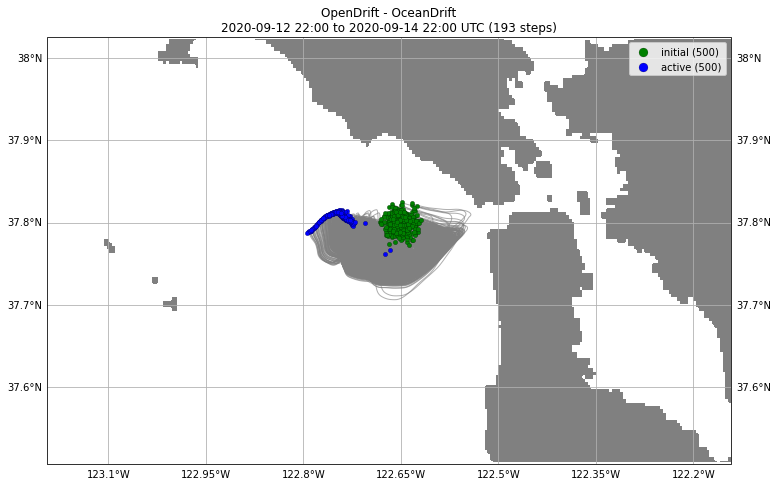

(<GeoAxesSubplot:title={'center':'OpenDrift - OceanDrift\n2020-09-12 22:00 to 2020-09-14 22:00 UTC (193 steps)'}>,
 <module 'matplotlib.pyplot' from '/home/pdaniel/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>)

In [11]:
o.plot(fast=True)

In [20]:
lats = o.get_lonlats()[1].data[0]
lons = o.get_lonlats()[0].data[0]
times = o.get_time_array()[0]

In [53]:
df = pd.DataFrame(data={'time':times,'lat':lats,'lon':lons})
df['ellapsed_hours'] = df['time'] - df['time'].iloc[0]
df['ellapsed_hours'] = df['ellapsed_hours'].apply(lambda x: (x.seconds/60/60) + x.days*24)

In [55]:
df.to_csv('Data/trajectory_dask_example.csv')

In [264]:
lats = o.get_lonlats()[1].data
lons = o.get_lonlats()[0].data
# fig, ax = make_map()

for i in range(lats.shape[1]):
    fig, ax = make_bathy_map(bathy)
    current_step = surface_map.isel(time=i)
    current_time = current_step['time'].values
    plot_radars(current_time,hfr2,ax)

    for j in range(len(lats[:,0])):

        if i <= 20:
            ax.plot(lons[j,0:i],lats[j,0:i],color='.35',zorder=110)
        else:
            ax.plot(lons[j,i-20:i],lats[j,i-20:i],color='.35',zorder=110)

    ax.scatter(lons[:,i],lats[:,i],zorder=115,color='g',linewidths=1,edgecolors='k')
    plt.text(.01,.01,"Hours: {}".format(i * 15 / 60 ),color='w', transform=ax.transAxes,zorder=200,size=18)
    plt.text(.02,1.01,"{}".format(current_time),color='k', transform=ax.transAxes,zorder=200,size=16)
    plt.savefig(f"Data/model_output/animation/sfBay_density_large_01_frame_{i:04}.png",dpi=60)
    plt.close()
    print("Finished {} out of {}".format(i,lats.shape[1]))

Finished 0 out of 193
Finished 1 out of 193
Finished 2 out of 193
Finished 3 out of 193
Finished 4 out of 193
Finished 5 out of 193
Finished 6 out of 193
Finished 7 out of 193
Finished 8 out of 193
Finished 9 out of 193
Finished 10 out of 193
Finished 11 out of 193
Finished 12 out of 193
Finished 13 out of 193
Finished 14 out of 193
Finished 15 out of 193
Finished 16 out of 193
Finished 17 out of 193
Finished 18 out of 193
Finished 19 out of 193
Finished 20 out of 193
Finished 21 out of 193
Finished 22 out of 193
Finished 23 out of 193
Finished 24 out of 193
Finished 25 out of 193
Finished 26 out of 193
Finished 27 out of 193
Finished 28 out of 193
Finished 29 out of 193
Finished 30 out of 193
Finished 31 out of 193
Finished 32 out of 193
Finished 33 out of 193
Finished 34 out of 193
Finished 35 out of 193
Finished 36 out of 193
Finished 37 out of 193
Finished 38 out of 193
Finished 39 out of 193
Finished 40 out of 193
Finished 41 out of 193
Finished 42 out of 193
Finished 43 out of 19

In [265]:
# filepaths
fp_in = "Data/model_output/animation/sfBay_density_large_01_frame*png"
fp_out = "Data/model_output/animation/density_animation_large-100.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=0)



'Dt/oe_uptaiainsBydniylre0_rm*n'

In [17]:
surface_map

<xarray.Dataset>
Dimensions:            (lat: 15, lon: 23, time: 193)
Coordinates:
  * time               (time) datetime64[ns] 2020-09-12T22:00:00 ... 2020-09-...
  * lon                (lon) float64 -122.8 -122.8 -122.8 ... -122.6 -122.5
  * lat                (lat) float64 37.7 37.71 37.72 ... 37.81 37.82 37.83
Data variables:
    projection_lonlat  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    density_surface    (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    density_submerged  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    density_stranded   (time, lat, lon) float64 nan nan nan nan ... nan nan nan